# LSRTM template

## Import modules

In [1]:
# Basic stuff
import sys
sys.path.append("/net/server/homes/sep/gbarnier/code/gpu/acousticIsoOp/test/lib/python/")
import genericIO
import SepVector
import Hypercube
import Acoustic_iso_double
import numpy as np
import time

# Solver library
import pyLCGsolver as LCG
import pyProblem as Prblm
import pyStopperBase as Stopper
from sys_util import logger

# Plotting library
import matplotlib.pyplot as plt
import sepPlot

## Wavelet

In [2]:
!Wavelet n1=1000 d1=0.008 fund=6. tdelay=1.0 wavelet=ricker2 | Add scale=-1.0 > wlt.H
# !Spectra < wlt.H | Graph grid=y max1=30 | Xtpen 

## Velocity models

In [3]:
# True velocity model
!/net/server/homes/sep/gbarnier/code/gpu/acousticIsoOp/test/bin/padFileGpuMain zPad=100 xPad=100 model=velocityMarmousi.H data=velocityMarmousi.pad.H

# Background velocity model
!Smooth rect1=5 rect2=5 < velocityMarmousi.H > velocityMarmousiStart.H
!/net/server/homes/sep/gbarnier/code/gpu/acousticIsoOp/test/bin/padFileGpuMain zPad=100 xPad=100 model=velocityMarmousiStart.H data=velocityMarmousiStart.pad.H

# True reflectivity 
!Add velocityMarmousi.H velocityMarmousiStart.H scale=1,-1 > reflectivityTrue.H
!/net/server/homes/sep/gbarnier/code/gpu/acousticIsoOp/test/bin/padFileGpuMain zPad=100 xPad=100 model=reflectivityTrue.H data=reflectivityTrue.pad.H

# Starting reflectiviy
!Add reflectivityTrue.pad.H scale=0 > modelStartLsrtm.pad.H

 
------------------------ Model padding program --------------------
Original nz = 350 [samples]
Original nx = 1700 [samples]
 
zPadMinus = 100 [samples]
zPadPlus = 110 [samples]
xPadMinus = 100 [samples]
xPadPlus = 104 [samples]
 
blockSize = 16 [samples]
FAT = 5 [samples]
 
New nz = 570 [samples including padding and FAT]
New nx = 1914 [samples including padding and FAT]
-------------------------------------------------------------------
 
 
------------------------ Model padding program --------------------
Original nz = 350 [samples]
Original nx = 1700 [samples]
 
zPadMinus = 100 [samples]
zPadPlus = 110 [samples]
xPadMinus = 100 [samples]
xPadPlus = 104 [samples]
 
blockSize = 16 [samples]
FAT = 5 [samples]
 
New nz = 570 [samples including padding and FAT]
New nx = 1914 [samples including padding and FAT]
-------------------------------------------------------------------
 
 
------------------------ Model padding program --------------------
Original nz = 350 [samples]
Original

## Generate data

### Initialize nonlinear operator

In [4]:
# Note: you need a "dummy arg" for the first argument to replace what would be the executable
args=["dummy arg","vel=velocityMarmousi.pad.H","model=wlt.H","par=parPythonTest.p","sources=wlt.H","nGpu=1"]
modelDouble,dataDouble,velDouble,parObject,sourcesVector,receiversVector=Acoustic_iso_double.nonlinearOpInitDouble(args)

# Printing parameter file for reference
!cat parPythonTest.p

nts=1000
dts=0.008
sub=8
nz=570
nx=1914
zPadMinus=100
zPadPlus=110
xPadMinus=100
xPadPlus=104
dz=0.01
dx=0.01
fMax=20
zSource=10
xSource=850
nShot=1
spacingShots=1
depthReceiver=10
nReceiver=1700
dReceiver=1
oReceiver=1
saveWavefield=0
wavefieldShotNumber=0
blockSize=16
fat=5
nGpu=8


### Create nonlinear object

In [5]:
nonlinearOp=Acoustic_iso_double.nonlinearPropShotsGpu(modelDouble,dataDouble,velDouble,parObject,sourcesVector,receiversVector)

### Read wavelet

In [6]:
modelFile=parObject.getString("sources")
modelFloat=genericIO.defaultIO.getVector(modelFile,ndims=3)
modelDMat=modelDouble.getNdArray()
modelSMat=modelFloat.getNdArray()
modelDMat[:]=modelSMat

### Nonlinear forward (generate seismic data)

In [7]:
# Conventional nonlinear operator
nonlinearOp.forward(False,modelDouble,dataDouble);

Deallocating fwd


### Plot data

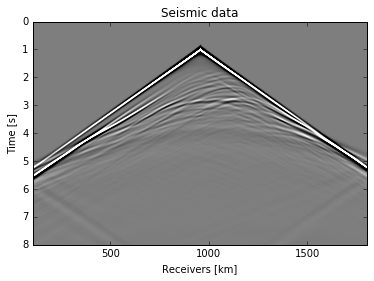

In [8]:
# Convert data to 2D float 
dataFloat2D=SepVector.getSepVector(Hypercube.hypercube(axes=[dataDouble.getHyper().axes[0],dataDouble.getHyper().axes[1]]))
dataFloat2DNd=dataFloat2D.getNdArray()
dataDoubleNd=dataDouble.getNdArray()
dataFloat2DNd[:]=dataDoubleNd

# Plot forward
sepPlot.Grey(plt,dataFloat2D,label1="Time [s]",label2="Receivers [km]",title="Seismic data").output()

# Run inversion

### Read starting model

In [9]:
# Read starting velocity model
modelStartLsrtmFloat=genericIO.defaultIO.getVector("modelStartLsrtm.pad.H",ndims=2)
modelStartLsrtmFloatNd=modelStartLsrtmFloat.getNdArray()

# Convert to double
modelStartLsrtmDouble=SepVector.getSepVector(modelStartLsrtmFloat.getHyper(),storage="dataDouble")
modelStartLsrtmDoubleNd=modelStartLsrtmDouble.getNdArray()
modelStartLsrtmDoubleNd[:]=modelStartLsrtmFloatNd

### Initialize Born operator

In [10]:
args=["dummy arg","vel=velocityMarmousiStart.pad.H","sources=wlt.H","par=parPythonTest.p","model=modelStartLsrtm.pad.H"]
modelDouble,dataDouble,velDouble,parObject,sourcesVector,sourcesSignalsVector,receiversVector=Acoustic_iso_double.BornOpInitDouble(args)

# Printing parameter file for reference
!cat parPythonTest.p

nts=1000
dts=0.008
sub=8
nz=570
nx=1914
zPadMinus=100
zPadPlus=110
xPadMinus=100
xPadPlus=104
dz=0.01
dx=0.01
fMax=20
zSource=10
xSource=850
nShot=1
spacingShots=1
depthReceiver=10
nReceiver=1700
dReceiver=1
oReceiver=1
saveWavefield=0
wavefieldShotNumber=0
blockSize=16
fat=5
nGpu=8


### Create Born operator

In [19]:
BornOp=Acoustic_iso_double.BornShotsGpu(modelDouble,dataDouble,velDouble,parObject,sourcesVector,sourcesSignalsVector,receiversVector)

### Construct FWI problem

In [23]:
# Create L2-norm linear problem
model_vec=modelStartLsrtmDouble.clone()
model_vec.zero()
L2Prob=Prblm.ProblemL2Linear(model_vec,dataDouble,BornOp)

# Create stopper
niter=10
Stop=Stopper.BasicStopper(niter=niter)

# # Create solver
LCGsolver=LCG.LCGsolver(Stop,logger=logger("test.log"))
LCGsolver.setDefaults(iter_buffer=None,iter_sampling=1)

# # Run solver
# LCGsolver.run(L2Prob)